# DES Y1 Likelihood for wCDM Model

*last tested with bayesfast commit 753db33*

**(Note)** This example needs to be updated for the latest BayesFast.

In [1]:
import os, sys
import numpy as np
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from scipy.stats import norm
from scipy.linalg import sqrtm
import bayesfast as bf
from threadpoolctl import threadpool_limits
threadpool_limits(1) # TODO: implement a bayesfast global thread controller

Getting the DES chains, which are not shipped with BayesFast.

In [2]:
if not os.path.exists('data/des-y1-w-chain-trimmed.txt'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/HerculesJack/bayesfast-example-data/master/des-y1-w-chain-trimmed.txt',
        'data/des-y1-w-chain-trimmed.txt')

Loading the DES chains.

In [3]:
x_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, :27].copy()
p_mn = np.loadtxt('data/des-y1-w-chain-trimmed.txt')[:, -1].copy()

Initializing the cosmosis pipeline.
We only use cosmosis to compute the models (2pt functions),
which are approximated by polynomial surrogates during sampling.
The remaining computation is implemented in the cells below,
which will be integrated into [CosmoFast](https://github.com/HerculesJack/cosmofast) later.

In [4]:
para_range = np.array([[0.1, 0.9], [0.55, 0.9], [0.03, 0.07], 
                       [0.87, 1.07], [0.5e-9, 5.0e-9], [0.0006, 0.01], 
                       [-2, -0.333], [0.8, 3.0], [0.8, 3.0], 
                       [0.8, 3.0], [0.8, 3.0], [0.8, 3.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-5.0, 5.0], [-5.0, 5.0], 
                       [-0.1, 0.1], [-0.1, 0.1], [-0.1, 0.1], 
                       [-0.1, 0.1], [-0.05, 0.05], [-0.05, 0.05], 
                       [-0.05, 0.05], [-0.05, 0.05], [-0.05, 0.05]])
init_mu = np.array([2.950000e-01,  6.881000e-01,  4.680000e-02,  
                    9.676000e-01, 2.260574e-09,  6.155000e-04, 
                    -1.000000e+00,  1.450000e+00, 1.550000e+00,  
                    1.650000e+00,  1.800000e+00,  2.000000e+00, 
                    1.200000e-02,  1.200000e-02,  1.200000e-02,  
                    1.200000e-02, 0.000000e+00,  0.000000e+00,  
                    2.000000e-03, -1.500000e-02, 7.000000e-03, 
                    -1.800000e-02,  2.000000e-03,  1.000000e-03, 
                    3.000000e-03,  0.000000e+00,  0.000000e+00])
init_sig = (para_range[:, 1] - para_range[:, 0]) / 1000
nonlinear_indices = np.array([0, 1, 2, 3, 4, 5, 6, 16, 17])
constrained_indices = np.array([0, 4, 6, 16, 17])

In [5]:
%%time
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
ini = Inifile("data/params.ini")
pipeline = LikelihoodPipeline(ini)
sys.stdout = old_stdout

CPU times: user 665 ms, sys: 810 ms, total: 1.48 s
Wall time: 6.1 s


In [6]:
%%time
start = pipeline.start_vector()
results = pipeline.run_results(start)

/global/u2/h/hejia/cosmosis/cosmosis-standard-library/intrinsic_alignments/la_model/linear_alignments.py:104: RuntimeWarning: invalid value encountered in true_divide
  r_I = P_GI / P_II * b_I


CPU times: user 7.04 s, sys: 0 ns, total: 7.04 s
Wall time: 7.07 s


In [7]:
_prior_indices = np.array([18, 19, 20, 21, 12, 13, 14, 15, 22, 23, 24, 25, 26])
_prior_mu = np.array([-0.001, -0.019, 0.009, -0.018, 0.012, 0.012, 0.012, 0.012,
                      0.008, -0.005, 0.006, 0.0, 0.0])
_prior_sig = np.array([0.016, 0.013, 0.011, 0.022, 0.023, 0.023, 0.023, 0.023, 
                       0.007, 0.007, 0.006, 0.01, 0.01])
_prior_norm = (
    -0.5 * np.sum(np.log(2 * np.pi * _prior_sig**2)) - np.sum(np.log(
    norm.cdf(para_range[_prior_indices, 1], _prior_mu, _prior_sig) -
    norm.cdf(para_range[_prior_indices, 0], _prior_mu, _prior_sig))) - 
    np.sum(np.log(para_range[:12,1] - para_range[:12,0])) - 
    np.sum(np.log(para_range[16:18,1] - para_range[16:18,0])))

_d = results.block['data_vector', '2pt_data']
_invC = results.block['data_vector', '2pt_inverse_covariance']
_invC_r = sqrtm(_invC)
_d_diag = _d @ _invC_r
_norm = results.block['data_vector', '2pt_norm']

def des_prior_f(x):
    chi2 = -0.5 * np.sum(((x[_prior_indices] - _prior_mu) / _prior_sig)**2)
    return chi2 + _prior_norm

def des_prior_j(x):
    foo = np.zeros((1, 27))
    foo[0, _prior_indices] = -(x[_prior_indices] - _prior_mu) / _prior_sig**2
    return foo

def des_2pt_theory(x):
    try:
        import os, sys
        os.environ['OMP_NUM_THREADS'] = '1'
        from cosmosis.runtime.config import Inifile
        from cosmosis.runtime.pipeline import LikelihoodPipeline

        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        ini = Inifile("data/params.ini")
        pipeline = LikelihoodPipeline(ini)
        sys.stdout = old_stdout
        res = pipeline.run_results(x)
        return res.block['data_vector', '2pt_theory'] @ _invC_r
    except Exception:
        return np.nan * np.ones(457)

def chi2_f(m):
    return np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm)

def chi2_fj(m):
    return (np.atleast_1d(-0.5 * np.sum((m - _d_diag)**2) + _norm), 
            -(m - _d_diag)[np.newaxis])

def des_post_f(like, x):
    return like + des_prior_f(x)

def des_post_fj(like, x):
    return like + des_prior_f(x), np.concatenate(
        (np.ones((1, 1)), des_prior_j(x)), axis=-1)

BayesFast is not documented yet. Below is a brief note on its usage.
Not all the functionality is used in this notebook.

* `Module` : analogous to cosmosis modules, with optional analytic Jacobian. 
  * ```
    __init__(self, fun=None, jac=None, fun_and_jac=None,
             input_vars=['__var__'], output_vars=['__var__'],
             delete_vars=[], concat_input=False, concat_output=False,
             input_scales=None, label=None, fun_args=(), fun_kwargs={},
             jac_args=(), jac_kwargs={}, fun_and_jac_args=(),
             fun_and_jac_kwargs={}):
    ```
  * You may define its `fun` and/or `jac` and/or `fun_and_jac`,
    and call them with `Module.fun` etc.
    When `Module.fun` is called, we will first check if you have defined its `fun`.
    If not, we will check if you have defined its `fun_and_jac`.
    If still not, an exception will be raised. Similar for `Module.jac` and `Module.fun_and_jac`.
  * You need to specify the name(s) of `input_vars` and `output_vars`
    as a list of strings, or a string if there is only one variable.
    This will be used to track the variables during the evaluation of the pipeline.
    All the variables should be stored and used as 1-d numpy arraies.
  * Let's say we have a `Module` with `input_vars` A and B, whose shapes are `(a,)` and `(b,)`.
    While the `output_vars` are C and D, whose shapes are `(c,)` and `(d,)`.
    Then the signature of its `fun` should be `(a,),(b,)->(c,),(d,)`.
    The signature of its `jac` should be `(a,),(b,)->(c,a+b),(d,a+b)`.
    The signature of its `fun_and_jac` should be `(a,),(b,)->((c,),(d,)),((c,a+b),(d,a+b))`.
  * For convenience, you can also use the arguments `concat_input` and `concat_output`.
    For the example above, if `concat_input` is True, 
    the input of `fun` should have shape `(a+b,)`.
    Assuming `a+b=e+f`, if `concat_input` is `(e,f)`, 
    the input should have shape `(e,f)`. Similar for `concat_output`.

In [8]:
bf.utils.random.set_generator(27) # set up the global random number generator
bf.utils.parallel.set_backend(64) # set up the global parallel backend

module_0 = bf.Module(fun=des_2pt_theory, input_vars='x',
                     output_vars='m')
module_1 = bf.Module(fun=chi2_f, fun_and_jac=chi2_fj,
                     input_vars='m', output_vars='like')
module_2 = bf.Module(fun=des_post_f, fun_and_jac=des_post_fj,
                     input_vars=['like', 'x'], output_vars='logp')

* `Pipeline`: analogous to cosmosis Pipeline.
  * ```
    __init__(self, module_list=[], surrogate_list=[],
             input_vars=['__var__'], input_shapes=None, input_scales=None,
             hard_bounds=True, copy_input=False, module_start=None,
             module_stop=None, original_space=True, use_surrogate=False)
    ```


* `Density`: derived from `Pipeline`, analogous to cosmosis LikelihoodPipeline.
  * ```
    __init__(self, density_name='__var__', decay_options={}, *args,
             **kwargs)
    ```
  * The overall input of `Density` should be a single array, 
    and you need to tell us how to split it using `input_vars` and `input_shapes`.
  * `args` / `kwargs`: additional arguments / keyword arguments to be passed to
    `Pipeline`.

In [9]:
density_0 = bf.Density(density_name='logp',
                       module_list=[module_0, module_1, module_2], 
                       input_vars='x', input_shapes=27, input_scales=para_range,
                       hard_bounds=True)
density_0(start), results.post

(array(5301.51629275), 5301.516292745906)

* `PolyConfig`: used to config `PolyModel`.
  * ```
    __init__(self, order, input_mask=None, output_mask=None, coef=None)
    ```
  * `order` should be one of `('linear', 'quadratic', 'cubic-2', 'cubic-3')`, 
    where `cubic-2` means cubic model without 'xyz' terms.
  * If you only want to define it on some of the input (output) variables,
    you can use `input_mask` (`output_mask`).


* `Surrogate`: derived from `Module`.
  * ```
    __init__(self, input_size=None, output_size=None, scope=(0, 1),
             fit_options={}, *args, **kwargs)
    ```
  * `scope`: `(i_step, n_step)`, e.g. `(0, 1)` means it will replace #0 `Module` in `module_list`.


* `PolyModel`: derived from `Surrogate`.
  * ```
    __init__(self, configs, bound_options={}, *args, **kwargs)
    ```
  * `configs` should be a `PolyConfig` or a list of them. 
    Or you can also just use its `order` if you don't need to set the masks.
    In this case, for example, `'quadratic'` will be interpreted as `('linear','quadratic')`.

Here, during optimization, we use 27-d linear model.
During sampling, we use 27-d linear plus 9-d quadratic model.

In [10]:
surro_0 = bf.modules.PolyModel('linear', input_size=27, output_size=457,
                               input_vars='x', output_vars='m',
                               input_scales=para_range)
pc_0 = bf.modules.PolyConfig('linear')
pc_1 = bf.modules.PolyConfig('quadratic', input_mask=nonlinear_indices)
surro_1 = bf.modules.PolyModel([pc_0, pc_1], input_size=27, output_size=457,
                               input_vars='x', output_vars='m',
                               input_scales=para_range)

We iterate the block quadratic model for two steps, and in the end, 
we use truncated importance sampling with n=2000 samples, while the weights w are truncated at < w >n^0.25.

At the beginning, you need to provide a bunch of `x_0` to fit the initial surrogate model.

In [11]:
def _in_bound(x, bound):
    xt = np.atleast_2d(x).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xt)], axis=0).astype(bool)

sample_trace_0 = {'n_chain': 8, 'n_iter': 2500, 'n_warmup': 1000}
sample_trace_1 = {'n_chain': 8, 'n_iter': 2000, 'n_warmup': 500}

x_0 = bf.utils.sobol.multivariate_normal(init_mu, np.diag(init_sig**2), 100)
x_0 = x_0[_in_bound(x_0, para_range)]

opt_0 = bf.recipe.OptimizeStep(surrogate_list=surro_0, alpha_n=2, x_0=x_0,
                               sample_trace=sample_trace_0)
sam_0 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=2, reuse_samples=1,
                             sample_trace=sample_trace_0)
sam_1 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=2, reuse_samples=1,
                             sample_trace=sample_trace_1)
pos_0 = bf.recipe.PostStep(n_is=2000, k_trunc=0.25, evidence_method='GBS')

rec_0 = bf.recipe.Recipe(density=density_0, optimize=opt_0,
                         sample=[sam_0, sam_1], post=pos_0)

In [12]:
rec_0.run()

 OptimizeStep proceeding: iter #0 finished, while current logp = 5332.069, logp_trans = 5247.832, delta_pq = -1.769.
 OptimizeStep proceeding: iter #1 finished, while current logp = 5333.330, logp_trans = 5249.393, delta_pp = 1.561, delta_pq = -1.321.
 OptimizeStep proceeding: iter #2 finished, while current logp = 5334.502, logp_trans = 5250.564, delta_pp = 1.171, delta_pq = 0.008.
 OptimizeStep proceeding: iter #3 finished, while current logp = 5334.548, logp_trans = 5250.573, delta_pp = 0.009, delta_pq = -0.005.
 OptimizeStep proceeding: we will use iter #3 as it has the highest logp_trans.



/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #6 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #6 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #7 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #7 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #2 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #2 : divide

 CHAIN #1 : sampling proceeding [ 500 / 2500 ], last 500 samples used 31.34 seconds, while divergence encountered in 30 sample(s). (warmup)
 CHAIN #2 : sampling proceeding [ 500 / 2500 ], last 500 samples used 32.61 seconds, while divergence encountered in 27 sample(s). (warmup)
 CHAIN #3 : sampling proceeding [ 500 / 2500 ], last 500 samples used 32.92 seconds, while divergence encountered in 33 sample(s). (warmup)
 CHAIN #0 : sampling proceeding [ 500 / 2500 ], last 500 samples used 33.31 seconds. (warmup)
 CHAIN #6 : sampling proceeding [ 500 / 2500 ], last 500 samples used 33.81 seconds, while divergence encountered in 29 sample(s). (warmup)
 CHAIN #4 : sampling proceeding [ 500 / 2500 ], last 500 samples used 35.07 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 500 / 2500 ], last 500 samples used 35.73 seconds, while divergence encountered in 29 sample(s). (warmup)
 CHAIN #5 : sampling proceeding [ 500 / 2500 ], last 500 samples used 36.01 seconds. (warmup)
 CHAIN #1 : sampli

/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #1 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #1 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #3 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #5 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #5 : divide

 CHAIN #0 : sampling proceeding [ 500 / 2500 ], last 500 samples used 53.58 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 500 / 2500 ], last 500 samples used 54.70 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 500 / 2500 ], last 500 samples used 55.38 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 500 / 2500 ], last 500 samples used 56.14 seconds. (warmup)
 CHAIN #6 : sampling proceeding [ 500 / 2500 ], last 500 samples used 56.09 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 500 / 2500 ], last 500 samples used 56.30 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 500 / 2500 ], last 500 samples used 58.21 seconds. (warmup)
 CHAIN #4 : sampling proceeding [ 500 / 2500 ], last 500 samples used 59.55 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 1000 / 2500 ], last 500 samples used 43.36 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 1000 / 2500 ], last 500 samples used 43.44 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 1000 / 2500 ], last 500 

/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #4 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #4 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #5 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #5 : divide by zero encountered in true_divide
  _grad += self.to_original_grad2(x) / _tog
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:183: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  return np.sum(np.log(np.abs(self.to_original_grad(x_trans))),
/global/u2/h/hejia/bayesfast/bayesfast/core/density.py:750: RuntimeWarning:  CHAIN #0 : divide

 CHAIN #3 : sampling proceeding [ 400 / 2000 ], last 400 samples used 36.79 seconds. (warmup)
 CHAIN #4 : sampling proceeding [ 400 / 2000 ], last 400 samples used 37.34 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 400 / 2000 ], last 400 samples used 39.03 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 400 / 2000 ], last 400 samples used 39.94 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 2000 ], last 400 samples used 39.93 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 400 / 2000 ], last 400 samples used 40.12 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 400 / 2000 ], last 400 samples used 43.86 seconds. (warmup)
 CHAIN #6 : sampling proceeding [ 400 / 2000 ], last 400 samples used 44.85 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 800 / 2000 ], last 400 samples used 29.66 seconds.
 CHAIN #2 : sampling proceeding [ 800 / 2000 ], last 400 samples used 28.45 seconds.
 CHAIN #4 : sampling proceeding [ 800 / 2000 ], last 400 samples used 31.39 se

Failed to load one of the kernels (n(z) or W(z)) needed to compute 2D spectra
Often this is because you are in a weird part of parameter space, but if it is 
consistent then you may wish to look into it in more detail. Set fata_errors=T to do so.
Pipeline failed on these parameters: [ 3.68351913e-01  6.85851272e-01  6.32784761e-02  9.17266738e-01
  3.41938943e-09  3.01016535e-03 -4.02893511e-01  1.60495291e+00
  1.54671527e+00  1.57127421e+00  1.87220995e+00  1.88051874e+00
 -1.57903832e-02  1.87810466e-02  2.20378210e-02 -9.70887412e-03
  3.10694967e-01 -3.76721874e+00 -6.57141299e-03 -5.84603941e-02
  2.03350831e-02 -2.87118071e-03  8.18156664e-03 -9.40732092e-03
  9.66553671e-03 -8.84540473e-03  4.54177627e-03]
/global/homes/h/hejia/.conda/envs/hejia@cori-3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consid


 ***** PostStep finished. ***** 



/global/u2/h/hejia/bayesfast/bayesfast/core/recipe.py:1328: RuntimeWarning: as of now, n_call does not take the possible logp calls during evidence evaluation into account.
  warnings.warn('as of now, n_call does not take the possible logp '


In [13]:
rec_0.get()._fields

('samples',
 'weights',
 'weights_trunc',
 'logp',
 'logq',
 'logz',
 'logz_err',
 'x_p',
 'x_q',
 'logp_p',
 'logq_q',
 'trace_p',
 'trace_q',
 'n_call',
 'x_max',
 'f_max')

In [14]:
rec_0.get().n_call

2626

In [15]:
rec_0.get().logz, rec_0.get().logz_err

(nan, nan)

In [20]:
np.isfinite(rec_0.get().weights_trunc).all()

False

In [23]:
np.where(~np.isfinite(rec_0.get().weights_trunc))

(array([1654]),)

Removed no burn in
Removed no burn in
Removed no burn in


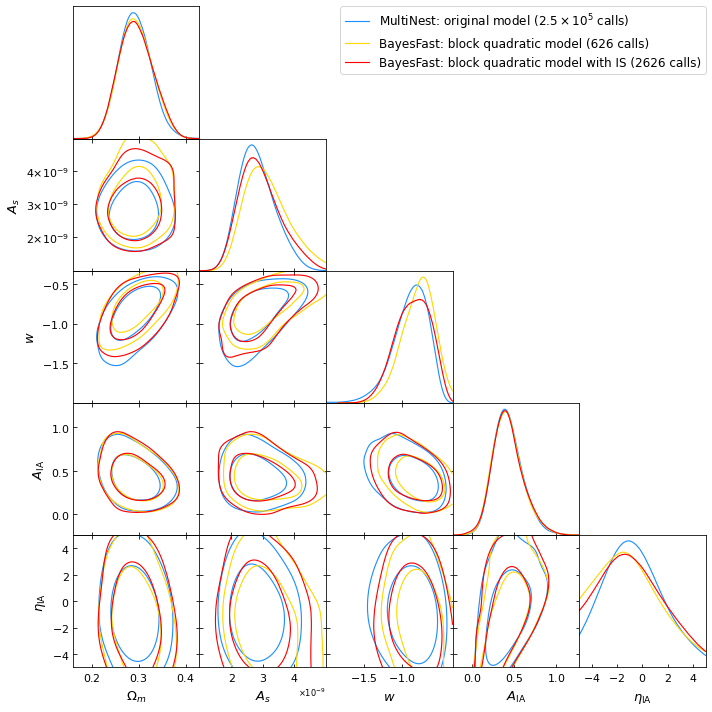

In [28]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
names = ["x%s"%i for i in range(5)]
labels =  ['\\Omega_m', 'A_s', 'w', 'A_{\\rm IA}', '\\eta_{\\rm IA}']
s_bf = MCSamples(
    samples=rec_0.get().samples[:, constrained_indices], names=names, 
    labels=labels, ranges=dict(zip(names, para_range[constrained_indices])), 
    label='BayesFast: block quadratic model (626 calls)')
s_mn = MCSamples(
    samples=x_mn[:, constrained_indices], weights=p_mn, names=names, 
    labels=labels, ranges=dict(zip(names, para_range[constrained_indices])), 
    label='MultiNest: original model ($2.5\\times10^5$ calls)')
s_bf_i = MCSamples(
    samples=np.concatenate((rec_0.get().samples[:, constrained_indices][:1654], rec_0.get().samples[:, constrained_indices][1655:])),
    weights=np.concatenate((rec_0.get().weights_trunc[:1654], rec_0.get().weights_trunc[1655:])), names=names, 
    labels=labels, ranges=dict(zip(names, para_range[constrained_indices])), 
    label='BayesFast: block quadratic model with IS (2626 calls)')
g = plots.getSubplotPlotter()
g.settings.figure_legend_loc = 'upper right'
g.settings.axes_fontsize = 14
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 15
g.settings.lw_contour = 2
g.settings.lw1 = 2
g.triangle_plot([s_mn, s_bf, s_bf_i], filled=False, contour_args={'alpha':1}, 
                diag1d_kwargs={'normalized':True}, contour_colors=['dodgerblue', 
                'gold', 'red'])
plt.show()